# 获取数据：GMD

数据分析的第一步是获取数据。本章将介绍如何从 [Global Macro Data](https://www.globalmacrodata.com) 获取全球宏观经济数据。该数据库涵盖了 243 个国家和地区的 46 个宏观经济变量，包括投资占GDP比重（inv_GDP）、出口占GDP 比重（exports_GDP）、政府支出占 GDP 比重（govexp_GDP）等。
有关该数据库的详细介绍参见：[GMD：最新全球宏观数据库-243个国家46个宏观变量](https://www.lianxh.cn/details/1559.html)。

我们将详细讲解以下内容：

1. 数据获取与清洗：如何下载并加载数据，处理缺失值和异常值。
2. 生成新变量：例如以美元计价的出口数据、出口占比等。
3. 数据可视化：通过静态和动态图表展示全球宏观经济趋势，包括时间序列图、堆积面积图和动画图表。

通过本章的学习，您将掌握从数据获取到可视化分析的完整流程，为后续的深入研究奠定基础。

## 将数据下载到本地

我们需要为本项目设定一个文件夹，将所有数据与脚本统一存放，例如 `D:\Github\dslian\body`。用 `os.chdir()` 切过去后，接着通过 `pd.read_csv()` 直接从网址读取 `GMD.csv`，约 9 MB，十余秒即可载入为 `DataFrame`。最后用 `to_csv()` 保存到本地 `data` 子目录，并设定 `index=False`，既留备份，也便于离线复现。


In [20]:
import pandas as pd
import os

os.chdir(r"D:\Github\dslian\body")  # 修改为你的工作路径

# 获取数据并加载到 DataFrame
''' 9M 左右，下载需要 10-15 秒
url = "https://www.globalmacrodata.com/GMD.csv"
data = pd.read_csv(url)

# 保存数据到 data 文件夹下
data.to_csv("data/GMD.csv", index=False)
'''

# 从 data 文件夹读取数据
data = pd.read_csv("data/GMD.csv")

# 查看前几行数据
# print(data.tail(5))

# 以列表形式输出所有列名
data.columns.to_list()

['countryname',
 'ISO3',
 'year',
 'nGDP',
 'rGDP',
 'rGDP_pc',
 'rGDP_USD',
 'deflator',
 'cons',
 'rcons',
 'cons_GDP',
 'inv',
 'inv_GDP',
 'finv',
 'finv_GDP',
 'exports',
 'exports_GDP',
 'imports',
 'imports_GDP',
 'CA',
 'CA_GDP',
 'USDfx',
 'REER',
 'govexp',
 'govexp_GDP',
 'govrev',
 'govrev_GDP',
 'govtax',
 'govtax_GDP',
 'govdef',
 'govdef_GDP',
 'govdebt',
 'govdebt_GDP',
 'HPI',
 'CPI',
 'infl',
 'pop',
 'unemp',
 'strate',
 'ltrate',
 'cbrate',
 'M0',
 'M1',
 'M2',
 'M3',
 'M4',
 'SovDebtCrisis',
 'CurrencyCrisis',
 'BankingCrisis']

## 中国的数据

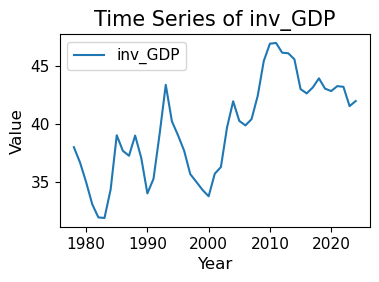

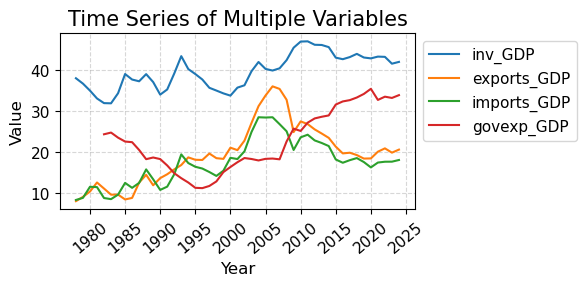

In [21]:
import matplotlib.pyplot as plt

# 选择变量列表和国家
vlist = ["inv_GDP", "exports_GDP", "imports_GDP", "govexp_GDP"]
cname = "CHN"

# 筛选出指定国家的数据
china_data = data[data["ISO3"] == cname]

# 选择样本范围
china_data = china_data[(china_data["year"] >= 1978) & (china_data["year"] <= 2024)]

# 绘制简单的时序图
plt.figure(figsize=(4,2.5))
plt.plot(china_data["year"], china_data["inv_GDP"], label="inv_GDP")
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Time Series of inv_GDP")
plt.legend(loc="upper left")
plt.grid()
plt.show()

# 绘制多变量时序图
plt.figure(figsize=(6, 3))
for var in vlist:
    plt.plot(china_data["year"], china_data[var], label=var)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Time Series of Multiple Variables")
plt.xticks(range(1980, 2026, 5), rotation=40)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()

### 出口份额占比

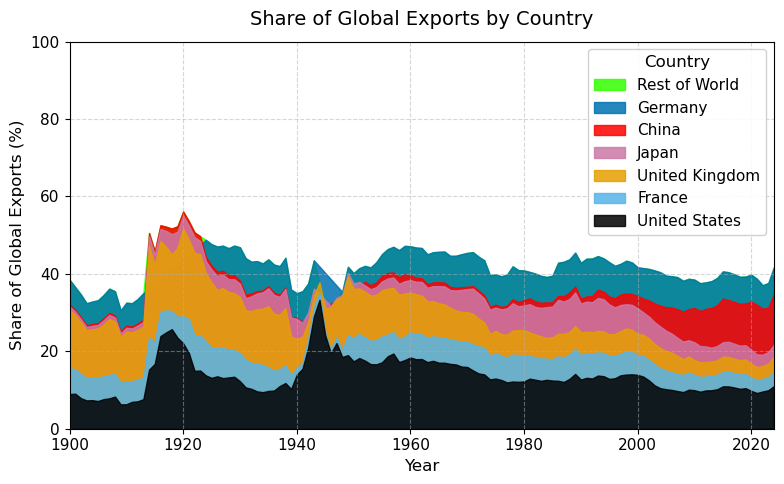

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 读取数据
data = pd.read_csv("data/GMD.csv")

# 定义年份范围与国家代码
start_year = 1900
end_year = 2024
cname = ["USA", "DEU", "FRA", "GBR", "JPN", "CHN"]

# 创建以美元计价的出口数据
data["exports_USD"] = data["exports"] / data["USDfx"]

# 删除数据质量较差的国家
invalid_countries = ["MMR", "SLE", "ROU", "ZWE", "POL", "YUG"]
data = data[~data["ISO3"].isin(invalid_countries)]

# 保留必要变量并选择样本区间
data = data[["ISO3", "year", "exports_USD"]].dropna()
data = data[(data["year"] >= start_year) & (data["year"] <= end_year)]

# 等价写法
data = data.query("@start_year <= year <= @end_year")
# 筛选出年份在指定范围内的数据
# 使用 start_year 和 end_year 变量定义的年份范围进行过滤
# 这里使用了 @varname 的方式来引用变量，@ 符号用于在 query 方法中直接引用 Python 变量
# 这种写法允许我们在 Pandas 的 query 方法中使用 Python 变量进行动态过滤

# 计算每年全球总出口额
data["total_exports"] = data.groupby("year")["exports_USD"].transform("sum")

# 计算每个国家出口占比
data["export_share"] = (data["exports_USD"] / data["total_exports"]) * 100

# 保留目标国家与其他国家
data = data[data["ISO3"].isin(cname) | (data["ISO3"] != "")]

# 计算其他国家（ROW）的出口占比
data["selected_sum"] = data.groupby("year")["export_share"].transform(
    lambda x: x if data["ISO3"].isin(cname).any() else 0
)
data["ROW_sum"] = data.groupby("year")["export_share"].transform(
    lambda x: x if ~data["ISO3"].isin(cname).any() else 0
)

# 创建排名变量并标注 ROW 与各国家
rank_map = {"USA": 1, "FRA": 2, "GBR": 3, "JPN": 4, "CHN": 5, "DEU": 6}
data["rank"] = data["ISO3"].map(rank_map)
data.loc[~data["ISO3"].isin(cname), "ISO3"] = "ROW"
data.loc[data["ISO3"] == "ROW", "export_share"] = data["ROW_sum"]

# 保留唯一值并排序，计算累计占比
data = data.drop_duplicates(subset=["ISO3", "year"]).sort_values(by=["year", "rank"])
data["cum_share"] = data.groupby("year")["export_share"].cumsum()

# 设置图形样式
mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 100,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.5
})

# 定义配色方案（对比度高）
bright_colors = {
    "ROW": "#33FF00",    # lime green
    "DEU": "#0072B2",    # blue
    "CHN": "#FF0000",    # red
    "JPN": "#CC79A7",    # purple pink
    "GBR": "#E69F00",    # orange
    "FRA": "#56B4E9",    # sky blue
    "USA": "#000000",    # black
}

# 定义图例名称映射（替换 ISO3 为更易懂的国家名）
label_map = {
    "ROW": "Rest of World",
    "USA": "United States",
    "DEU": "Germany",
    "FRA": "France",
    "GBR": "United Kingdom",
    "JPN": "Japan",
    "CHN": "China"
}

# 绘制图形
plt.figure(figsize=(8, 5))
for country in ["ROW", "DEU", "CHN", "JPN", "GBR", "FRA", "USA"]:
    subset = data[data["ISO3"] == country]
    plt.fill_between(subset["year"], 
                     subset["cum_share"],
                     label=label_map[country],
                     color=bright_colors[country],
                     alpha=0.85)

# 设置标题、标签和图例
plt.xlabel("Year")
plt.ylabel("Share of Global Exports (%)")
plt.title("Share of Global Exports by Country", pad=12)
plt.ylim(0, 100)
plt.xlim(start_year, end_year)

# 图例设置：右上角、白色背景、透明框
plt.legend(title="Country", loc="upper right", 
           frameon=True, framealpha=0.9, facecolor="white")
plt.tight_layout()
plt.show()


### 动态图形

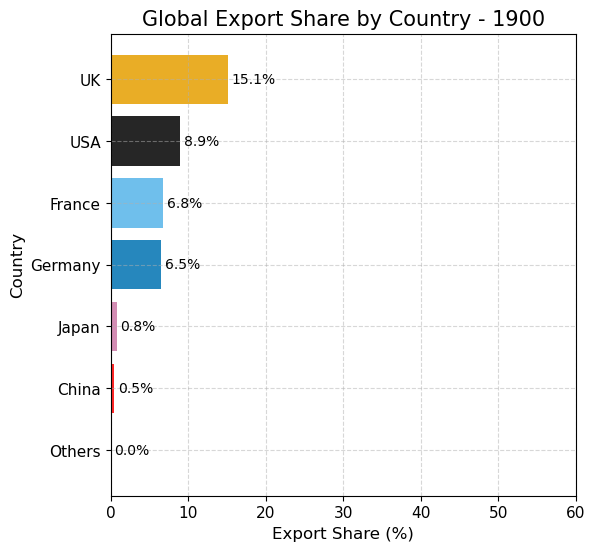

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation

# 下载数据
# url = "https://www.globalmacrodata.com/GMD.csv"
# data = pd.read_csv(url)

# 读取数据
data = pd.read_csv("data/GMD.csv")

# 参数设置
start_year = 1900
end_year = 2024
year_interval = 2  # 动画间隔
years = list(range(start_year, end_year + 1, year_interval))
cname = ["USA", "DEU", "FRA", "GBR", "JPN", "CHN"]

# 数据处理
# 将出口数据转换为以美元计价
data["exports_USD"] = data["exports"] / data["USDfx"]

# 删除数据质量较差的国家
data = data[~data["ISO3"].isin(["MMR", "SLE", "ROU", "ZWE", "POL", "YUG"])]

# 保留必要的变量并删除缺失值
data = data[["ISO3", "year", "exports_USD"]].dropna()

# 筛选出指定年份范围内的数据
data = data[(data["year"] >= start_year) & (data["year"] <= end_year)]

# 计算每年全球总出口额
data["total_exports"] = data.groupby("year")["exports_USD"].transform("sum")

# 计算每个国家的出口占比
data["export_share"] = data["exports_USD"] / data["total_exports"] * 100

# 保留目标国家和其他国家的数据
data = data[data["ISO3"].isin(cname) | (data["ISO3"] != "")]

# 计算目标国家的出口占比总和
data["selected_sum"] = data.groupby("year")["export_share"].transform(
    lambda x: x if data["ISO3"].isin(cname).any() else 0
)

# 计算其他国家（ROW）的出口占比总和
data["ROW_sum"] = data.groupby("year")["export_share"].transform(
    lambda x: x if ~data["ISO3"].isin(cname).any() else 0
)

# 将非目标国家标记为 "ROW" 并更新其出口占比
data.loc[~data["ISO3"].isin(cname), "ISO3"] = "ROW"
data.loc[data["ISO3"] == "ROW", "export_share"] = data["ROW_sum"]

# 删除重复值，确保每个国家每年只有一条记录
data = data.drop_duplicates(subset=["ISO3", "year"])

# 设置样式
mpl.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "figure.dpi": 100,
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.5
})

# 颜色与国家名映射
bright_colors = {
    "ROW": "#33FF00",
    "DEU": "#0072B2",
    "CHN": "#FF0000",
    "JPN": "#CC79A7",
    "GBR": "#E69F00",
    "FRA": "#56B4E9",
    "USA": "#000000",
}
label_map = {
    "ROW": "Others",
    "USA": "USA",
    "DEU": "Germany",
    "FRA": "France",
    "GBR": "UK",
    "JPN": "Japan",
    "CHN": "China"
}

# 创建动画
fig, ax = plt.subplots(figsize=(6, 6))

def update(year):
    ax.clear()
    year_data = data[data["year"] == year].copy()
    year_data = year_data.groupby("ISO3")["export_share"].sum().reset_index()
    year_data = year_data.sort_values("export_share", ascending=True)
    
    bars = ax.barh(
        [label_map[c] for c in year_data["ISO3"]],
        year_data["export_share"],
        color=[bright_colors.get(c, "#999999") for c in year_data["ISO3"]],
        alpha=0.85
    )
    
    for bar, val in zip(bars, year_data["export_share"]):
        ax.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                f"{val:.1f}%", va='center', fontsize=10)

    ax.set_xlim(0, 60)
    ax.set_title(f"Global Export Share by Country - {year}")
    ax.set_xlabel("Export Share (%)")
    ax.set_ylabel("Country")
    ax.grid(True, axis="x", linestyle="--", alpha=0.5)

ani = animation.FuncAnimation(fig, update, frames=years, interval=600, repeat=False)

# 保存动画（也可改为 .mp4 需要 ffmpeg）
ani.save("figs/export_share_animation.gif", writer="pillow", dpi=120)


In [ ]:
# 显示 GIF 动图
from IPython.display import Image
Image(filename="figs/export_share_animation.gif")

![Export Share Animation](figs/export_share_animation.gif)

<!-- ![](https://fig-lianxh.oss-cn-shenzhen.aliyuncs.com/export_share_animation.gif) -->

## 出口份额排名分析

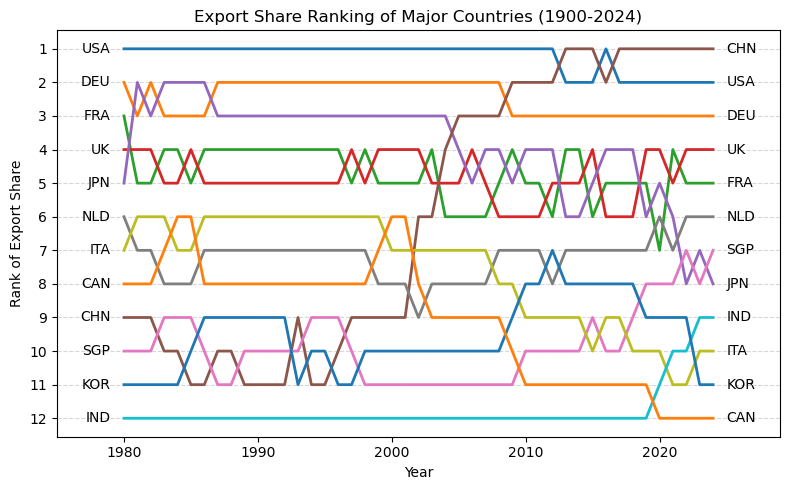

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# 读取数据
data = pd.read_csv("data/GMD.csv")

# 主要国家列表
cname = ["USA", "DEU", "FRA", "GBR", "JPN", "CHN", "SGP", "NLD", "ITA", "IND", "KOR", "CAN"]
label_map = {
    "GBR": "UK"
}
start_year = 1980
end_year = 2024

# 计算出口占比
data = data.copy()
if "exports_USD" not in data.columns:
    data["exports_USD"] = data["exports"] / data["USDfx"]
data["total_exports"] = data.groupby("year")["exports_USD"].transform("sum")
data["export_share"] = data["exports_USD"] / data["total_exports"] * 100

# 只保留主要国家和年份范围
rank_data = data[data["ISO3"].isin(cname) & (data["year"] >= start_year) & (data["year"] <= end_year)].copy()

# 计算每年出口排名（1为最大）
rank_data["rank"] = rank_data.groupby("year")["export_share"].rank(ascending=False, method="min")

# 绘制 bump chart
plt.figure(figsize=(8, 5))
for country in cname:
    country_data = rank_data[rank_data["ISO3"] == country]
    plt.plot(
        country_data["year"],
        country_data["rank"],
        label=label_map.get(country, country),
        linewidth=2
    )
    # 标注起止年份的国家名
    if not country_data.empty:
        plt.text(
            country_data["year"].min() - 1,
            country_data["rank"].iloc[0],
            label_map.get(country, country),
            va="center", ha="right", fontsize=10
        )
        plt.text(
            country_data["year"].max() + 1,
            country_data["rank"].iloc[-1],
            label_map.get(country, country),
            va="center", ha="left", fontsize=10
        )

plt.gca().invert_yaxis()  # 排名1在上
plt.yticks(np.arange(1, len(cname) + 1))
plt.xlabel("Year")
plt.ylabel("Rank of Export Share")
plt.title("Export Share Ranking of Major Countries (1900-2024)")
plt.xlim(start_year - 5, end_year + 5)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

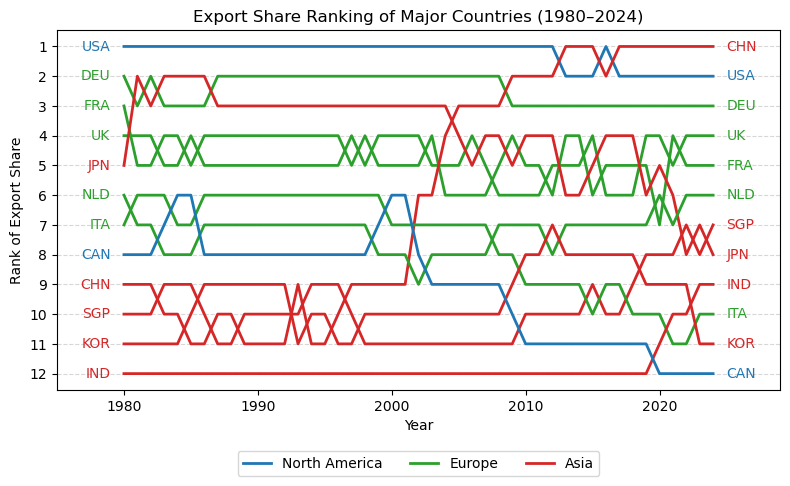

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# 读取数据
data = pd.read_csv("data/GMD.csv")

# 主要国家列表
cname = ["USA", "DEU", "FRA", "GBR", "JPN", "CHN", "SGP", "NLD", "ITA", "IND", "KOR", "CAN"]
label_map = {
    "GBR": "UK"
}
start_year = 1980
end_year = 2024

# 地区分组与颜色映射
country_region = {
    "USA": "North America", "CAN": "North America",
    "DEU": "Europe", "FRA": "Europe", "GBR": "Europe",
    "ITA": "Europe", "NLD": "Europe",
    "CHN": "Asia", "JPN": "Asia", "KOR": "Asia",
    "IND": "Asia", "SGP": "Asia"
}
region_colors = {
    "North America": "tab:blue",
    "Europe": "tab:green",
    "Asia": "tab:red"
}

# 计算出口占比
data = data.copy()
if "exports_USD" not in data.columns:
    data["exports_USD"] = data["exports"] / data["USDfx"]
data["total_exports"] = data.groupby("year")["exports_USD"].transform("sum")
data["export_share"] = data["exports_USD"] / data["total_exports"] * 100

# 筛选数据
rank_data = data[data["ISO3"].isin(cname) & (data["year"] >= start_year) & (data["year"] <= end_year)].copy()

# 计算排名（1为最大）
rank_data["rank"] = rank_data.groupby("year")["export_share"].rank(ascending=False, method="min")

# 绘图
plt.figure(figsize=(8, 5))

for country in cname:
    country_data = rank_data[rank_data["ISO3"] == country]
    region = country_region.get(country, "Other")
    color = region_colors.get(region, "gray")
    label = label_map.get(country, country)

    plt.plot(
        country_data["year"],
        country_data["rank"],
        label=label,
        linewidth=2,
        color=color
    )

    # 添加起止年份标签
    if not country_data.empty:
        plt.text(
            country_data["year"].min() - 1,
            country_data["rank"].iloc[0],
            label,
            va="center", ha="right", fontsize=10,
            color=color
        )
        plt.text(
            country_data["year"].max() + 1,
            country_data["rank"].iloc[-1],
            label,
            va="center", ha="left", fontsize=10,
            color=color
        )

# 图形美化
plt.gca().invert_yaxis()  # 排名 1 在顶部
plt.yticks(np.arange(1, len(cname) + 1))
plt.xlabel("Year")
plt.ylabel("Rank of Export Share")
plt.title("Export Share Ranking of Major Countries (1980–2024)")
plt.xlim(start_year - 5, end_year + 5)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 自定义图例（按地区）
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="tab:blue", lw=2, label="North America"),
    Line2D([0], [0], color="tab:green", lw=2, label="Europe"),
    Line2D([0], [0], color="tab:red", lw=2, label="Asia")
]
plt.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.show()


## 柱状图


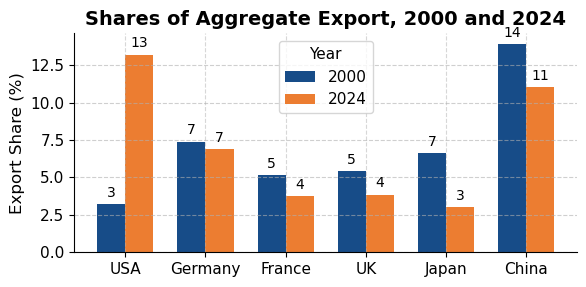

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 cname 顺序为：["USA", "CHN", "DEU", "JPN", "FRA", "GBR"]
# label_map 是国家名映射，如 {"USA": "美国", ...}

# 筛选 2000 和 2024 年
selected_years = [2000, 2024]
filtered_data = data[data["year"].isin(selected_years) & data["ISO3"].isin(cname)]
filtered_data = filtered_data.sort_values(by=["year", "ISO3"])

# 准备数据
data_2000 = filtered_data[filtered_data["year"] == 2000]["export_share"].values
data_2024 = filtered_data[filtered_data["year"] == 2024]["export_share"].values

# 位置设置
x = np.arange(len(cname))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 3))

# 绘图（采用 Figure 9B 的配色风格）
bars1 = ax.bar(x - width / 2, data_2000, width, label="2000", color="#174c88")  # 深蓝色
bars2 = ax.bar(x + width / 2, data_2024, width, label="2024", color="#ec7d31")  # 橙色

# 添加文字标签
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(bars1)
autolabel(bars2)

# 设定坐标轴和标题
ax.set_ylabel("Export Share (%)", fontsize=12)
ax.set_title("Shares of Aggregate Export, 2000 and 2024", fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels([label_map[c] for c in cname], rotation=0)
ax.legend(title="Year")

# 添加 y 轴网格线
ax.yaxis.grid(True, linestyle="--", alpha=0.6)

# 清理图框边线
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


在上图中，`export_share` 是每个国家的出口额占全球总出口额的百分比，其定义公式如下：

$$
\text{export\_share} = \frac{\text{exports\_USD}}{\text{total\_exports}} \times 100
$$

其中：
- `exports_USD` 是该国家的出口额（以美元计价）。
- `total_exports` 是当年全球所有国家的出口总额（以美元计价）。
- 结果乘以 100，将比例转换为百分比。

这个指标表示某个国家在全球出口总额中所占的份额，用于衡量该国家在全球贸易中的相对重要性。

`export_share` 和 `cum_share` 的区别在于它们的计算方式和用途：

1. **`export_share`**:
    - 表示某个国家在某一年中，其出口额占全球总出口额的百分比。
    - 是一个单独国家的指标，直接反映该国家在全球出口中的相对重要性。
    - 计算公式为：

      $$
      \mathrm{export\_share} = \frac{\mathrm{exports\_USD}}{\mathrm{total\_exports}} \times 100
      $$

2. **`cum_share`**:
    - 表示某一年中，按国家排名累加的出口占比。
    - 是一个累计指标，反映从排名靠前的国家开始，逐步累加的出口占比。
    - 例如，如果某一年中：
      - 国家 A 的 `export_share` 是 10%，
      - 国家 B 的 `export_share` 是 15%，
      - 国家 C 的 `export_share` 是 20%，
      - 那么它们的 `cum_share` 分别是：
         - 国家 A：10%
         - 国家 B：10% + 15% = 25%
         - 国家 C：10% + 15% + 20% = 45%

### 总结
- `export_share` 是单个国家的出口占比。
- `cum_share` 是按排名累加的出口占比，用于展示多个国家的累计贡献。